# Assignment 02 - CIFAR10 Image Classification


In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import cv2

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# devkit_path = Path('/Users/andrewlee/Desktop/645_Final/devkit')
train_path = Path('/content/drive/MyDrive/ENEL645/Project/Data/cars_train')
test_path = Path('/content/drive/MyDrive/ENEL645/Project/Data/cars_test')

In [ ]:
cars_meta = loadmat('/content/drive/MyDrive/ENEL645/Project/Data/cars_meta.mat')
cars_train_annos = loadmat('/content/drive/MyDrive/ENEL645/Project/Data/cars_train_annos.mat')
cars_test_annos = loadmat('/content/drive/MyDrive/ENEL645/Project/Data/cars_test_annos.mat')

In [ ]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [ ]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path/f for f in df_train['fname']] #  Appending Path
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,/content/drive/MyDrive/ENEL645/Project/Data/ca...
1,36,116,868,587,2,/content/drive/MyDrive/ENEL645/Project/Data/ca...
2,85,109,601,381,90,/content/drive/MyDrive/ENEL645/Project/Data/ca...
3,621,393,1484,1096,133,/content/drive/MyDrive/ENEL645/Project/Data/ca...
4,14,36,133,99,105,/content/drive/MyDrive/ENEL645/Project/Data/ca...


In [ ]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,/content/drive/MyDrive/ENEL645/Project/Data/ca...,Audi TTS Coupe 2012
1,36,116,868,587,2,/content/drive/MyDrive/ENEL645/Project/Data/ca...,Acura TL Sedan 2012
2,85,109,601,381,90,/content/drive/MyDrive/ENEL645/Project/Data/ca...,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,/content/drive/MyDrive/ENEL645/Project/Data/ca...,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,/content/drive/MyDrive/ENEL645/Project/Data/ca...,Ford F-450 Super Duty Crew Cab 2012


In [ ]:
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [test_path/f for f in df_test['fname']] #  Appending Path
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,/content/drive/MyDrive/ENEL645/Project/Data/ca...
1,100,19,576,203,/content/drive/MyDrive/ENEL645/Project/Data/ca...
2,51,105,968,659,/content/drive/MyDrive/ENEL645/Project/Data/ca...
3,67,84,581,407,/content/drive/MyDrive/ENEL645/Project/Data/ca...
4,140,151,593,339,/content/drive/MyDrive/ENEL645/Project/Data/ca...


In [ ]:
# Returns (Image, title, rectangle patch) for drawing
def get_assets(df, i):
    is_train = df is df_train
    folder = train_path if is_train else test_path
    image = Image.open(df['fname'][i])
    title = df['labels'][i] if is_train else 'Unclassified'

    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

In [ ]:
def display_image(df, i):
    image, title, rect = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title, rect = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
        im, title, rect = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        

In [ ]:
freq_labels = df_train.groupby('labels').count()[['class']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()

,count
labels,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47


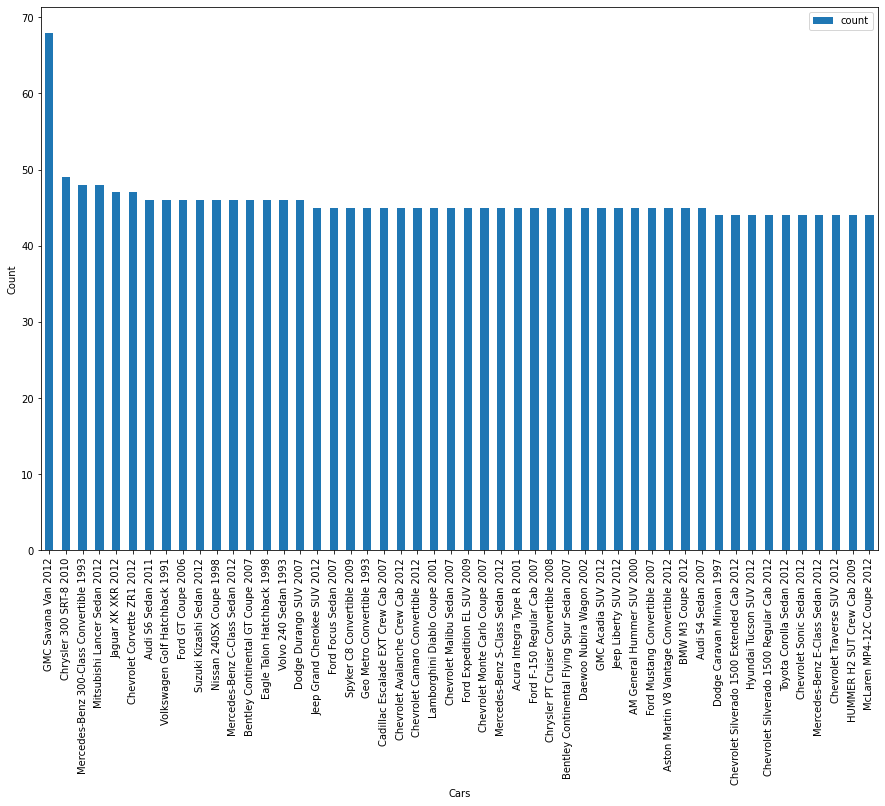

In [ ]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
names = pd.read_csv('/content/drive/MyDrive/ENEL645/Project/Data/names.csv')
names = names.values

## 7. Train your model

In [ ]:
np.random.shuffle(names)

## 8. Test your model

In [ ]:
nr_cars = 195

In [ ]:
idx_to_name = {x : names[x][0] for x in np.arange(nr_cars)}
name_to_idx = {x:i for i,x in enumerate(idx_to_name.values())}

In [ ]:
idx_to_name

{0: 'Dodge Dakota Crew Cab 2010',
 1: 'Volkswagen Golf Hatchback 1991',
 2: 'Suzuki Kizashi Sedan 2012',
 3: 'Ford Ranger SuperCab 2011',
 4: 'Audi 100 Wagon 1994',
 5: 'Ford Edge SUV 2012',
 6: 'Dodge Caliber Wagon 2007',
 7: 'Ford Mustang Convertible 2007',
 8: 'Audi S4 Sedan 2012',
 9: 'Ford F-450 Super Duty Crew Cab 2012',
 10: 'Mercedes-Benz E-Class Sedan 2012',
 11: 'GMC Yukon Hybrid SUV 2012',
 12: 'Mazda Tribute SUV 2011',
 13: 'Bugatti Veyron 16.4 Convertible 2009',
 14: 'Chevrolet Avalanche Crew Cab 2012',
 15: 'MINI Cooper Roadster Convertible 2012',
 16: 'Dodge Durango SUV 2012',
 17: 'Geo Metro Convertible 1993',
 18: 'Chevrolet Monte Carlo Coupe 2007',
 19: 'Dodge Ram Pickup 3500 Crew Cab 2010',
 20: 'Plymouth Neon Coupe 1999',
 21: 'Daewoo Nubira Wagon 2002',
 22: 'Lamborghini Aventador Coupe 2012',
 23: 'Chrysler Aspen SUV 2009',
 24: 'Chevrolet Traverse SUV 2012',
 25: 'Suzuki SX4 Hatchback 2012',
 26: 'Land Rover Range Rover SUV 2012',
 27: 'Audi A5 Coupe 2012',
 28: 

In [ ]:
train_path = '/content/drive/MyDrive/ENEL645/Project/Data/car_data/car_data/train/'
test_path = '/content/drive/MyDrive/ENEL645/Project/Data/car_data/car_data/test/'

In [ ]:
def get_data(path):
    train = []
    for i, name in enumerate(name_to_idx.keys()):
        new_path = path + name + "/"
        [train.append([i, cv2.resize(cv2.imread(img), (244,244), interpolation = cv2.INTER_AREA)]) for img in glob.glob(new_path + "*.jpg")]
    return np.array(train)

In [ ]:
train = get_data(train_path)
test = get_data(test_path)

In [ ]:
X_train = np.concatenate(train[:,1], axis=0).reshape(len(train), 244, 244, 3)
X_train = X_train / 255.0
X_train = X_train.astype('float32')
y_train = train[:,0]
y_train = np.eye(len(idx_to_name))[list(y_train)]

X_test = np.concatenate(test[:,1], axis=0).reshape(len(test), 244, 244, 3)
X_test = X_test / 255.0
X_test = X_test.astype('float32')
y_test = test[:,0]
y_test = np.eye(len(idx_to_name))[list(y_test)]

In [ ]:
X_train.shape

In [ ]:
def my_model_cnn(ishape = (244,244,3),k = 196, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    flat = tf.keras.layers.Flatten()(l5_drop)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [ ]:
model2 = my_model_cnn()
print(model2.summary())

In [ ]:
# reduce learning rate by 0.1 when the validation error plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))
 
# set the SGD optimizer with lr of 0.01 and momentum of 0.9
optimizer = SGD(lr = 0.01, momentum = 0.9)

#Monitor Callback
monitor = tf.keras.callbacks.ModelCheckpoint(model2, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
 
# compile the model
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# train the model
# call the reduce_lr value using callbacks in the training method
history = model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test),
    verbose=0, callbacks=[reduce_lr])